### Multi-class Support Vector Machine

#### Tính hàm mất mát và đạo hàm của nó bằng cách naive

In [2]:
import numpy as np
from random import shuffle

def svm_loss_naive(W, X, y, reg):
    d, C = W.shape
    N = X.shape[1]

    # naive loss and grad
    loss = 0
    dW = np.zeros_like(W)
    for n in range(N):
        xn = X[:, n]
        score = W.T.dot(xn)
        for j in range(C):
            if j == y[n]: continue
            margin = 1 - score[y[n]] + score[j]
            if margin > 0:
                loss += margin
                dW[:, j] += xn
                dW[:, y[n]] -= xn
    loss /= N 
    loss += 0.5*reg*np.sum(W * W) # regularization
    
    dW /= N 
    dW += reg*W # gradient off regularization 
    return loss, dW

# random, small data
N, C, d = 10, 3, 5
reg = .1 
W = np.random.randn(d, C)
X = np.random.randn(d, N)
y = np.random.randint(C, size = N)

# sanity check
print('loss without regularization:', svm_loss_naive(W, X, y, 0)[0])
print('loss with regularization:', svm_loss_naive(W, X, y, .1)[0])

loss without regularization: 4.1712152596143985
loss with regularization: 4.7286817569012864


In [5]:
f = lambda W: svm_loss_naive(W, X, y, .1)[0]

# for checking if calculated grad is correct
def numerical_grad_general(W, f):
    eps = 1e-6
    g = np.zeros_like(W)
    # flatening variable -> 1d. Then we need 
    # only one for loop
    W_flattened = W.flatten()
    g_flattened = np.zeros_like(W_flattened)
    
    for i in range(W.size):
        W_p = W_flattened.copy()
        W_n = W_flattened.copy()
        W_p[i] += eps 
        W_n[i] -= eps 
        
        # back to shape of W 
        W_p = W_p.reshape(W.shape)
        W_n = W_n.reshape(W.shape)
        g_flattened[i] = (f(W_p) - f(W_n))/(2*eps)
        
    # convert back to original shape
    return g_flattened.reshape(W.shape) 

# compare two ways of computing gradient
g1 = svm_loss_naive(W, X, y, .1)[1]
g2 = numerical_grad_general(W, f)
print('gradient difference: %f' %np.linalg.norm(g1 - g2))
# this should be very small


gradient difference: 0.000000


#### Tính hàm mất mát và đạo hàm của nó bằng cách vectorized

In [6]:
# more efficient way to compute loss and grad
def svm_loss_vectorized(W, X, y, reg):
    d, C = W.shape 
    _, N = X.shape 
    loss = 0 
    dW = np.zeros_like(W)
    
    Z = W.T.dot(X)     
    
    correct_class_score = np.choose(y, Z).reshape(N,1).T     
    margins = np.maximum(0, Z - correct_class_score + 1) 
    margins[y, np.arange(margins.shape[1])] = 0
    loss = np.sum(margins, axis = (0, 1))
    loss /= N 
    loss += 0.5 * reg * np.sum(W * W)
    
    F = (margins > 0).astype(int)
    F[y, np.arange(F.shape[1])] = np.sum(-F, axis = 0)
    dW = X.dot(F.T)/N + reg*W
    return loss, dW

In [7]:
N, C, d = 49000, 10, 3073
reg = .1 
W = np.random.randn(d, C)
X = np.random.randn(d, N)
y = np.random.randint(C, size = N)

import time 
t1 = time.time()
l1, dW1 = svm_loss_naive(W, X, y, reg)
t2 = time.time()
print( 'Naive     : run time:', t2 - t1, '(s)')

t1 = time.time()
l2, dW2 = svm_loss_vectorized(W, X, y, reg)
t2 = time.time()
print( 'Vectorized: run time:', t2 - t1, '(s)')
print( 'loss difference:', np.linalg.norm(l1 - l2))
print( 'gradient difference:', np.linalg.norm(dW1 - dW2))

Naive     : run time: 10.227906703948975 (s)
Vectorized: run time: 0.3715059757232666 (s)
loss difference: 4.547473508864641e-13
gradient difference: 2.657149089789924e-14


#### Gradient Descent cho Multi-class SVM

In [9]:
# Mini-batch gradient descent
def multiclass_svm_GD(X, y, Winit, reg, lr=.1, \
        batch_size = 100, num_iters = 1000, print_every = 100):
    W = Winit 
    loss_history = np.zeros((num_iters))
    for it in range(num_iters):
        # randomly pick a batch of X
        idx = np.random.choice(X.shape[1], batch_size)
        X_batch = X[:, idx]
        y_batch = y[idx]

        loss_history[it], dW = \
            svm_loss_vectorized(W, X_batch, y_batch, reg)

        W -= lr*dW 
        if it % print_every == 1:
            print( 'it %d/%d, loss = %f' \
                %(it, num_iters, loss_history[it]))

    return W, loss_history 

N, C, d = 49000, 10, 3073
reg = .1 
W = np.random.randn(d, C)
X = np.random.randn(d, N)
y = np.random.randint(C, size = N)

W, loss_history = multiclass_svm_GD(X, y, W, reg)

it 1/1000, loss = 1785.151898
it 101/1000, loss = 247.055379
it 201/1000, loss = 60.929262
it 301/1000, loss = 39.451484
it 401/1000, loss = 38.841549
it 501/1000, loss = 47.290492
it 601/1000, loss = 40.247016
it 701/1000, loss = 36.121091
it 801/1000, loss = 41.923936
it 901/1000, loss = 36.898044


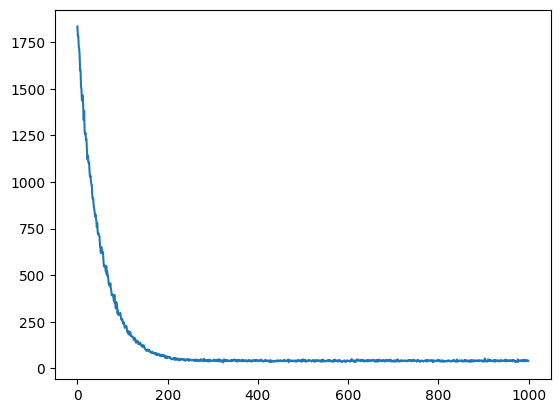

In [12]:
import matplotlib.pyplot as plt
# plot loss as a function of iteration
plt.plot(loss_history)
plt.show()
